In [11]:
%reload_ext autoreload
%autoreload 2


In [12]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

import matplotlib.pyplot as plt
from scipy import signal as sg

dt = 392e-9
fs = 1 / dt  # waveform sample rate

R1 = 200
C1 = 10e-9
R2 = 180
C2 = 33e-9

tau1 = R1 * C1
tau2 = R2 * C2

zpk_analog = [], [-1 / tau1, -1 / tau2], 1 / tau1 / tau2
zpk_dig = sg.bilinear_zpk(*zpk_analog, fs)
b, a = sg.zpk2tf(*zpk_dig)

# cryo_filter = sg.dlti(b, a, dt=dt)
_trap_filter = b, a, dt

In [13]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

import cvxpy as cx
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg

from pytrans import objectives as obj
from pytrans.solver import solver, TrapFilterTransform, init_waveform


n_samples = 256
_t = np.arange(n_samples)
voltage0 = sg.sawtooth(2 * np.pi * 4 * _t / _t.max(), width=0.5)
n_pad = 50
trap_filter = TrapFilterTransform(_trap_filter, pad_after=n_pad)

waveform0 = init_waveform(n_samples, 1)
waveform_filtered = trap_filter.transform(waveform0)

objectives = []

for j, v in enumerate(voltage0):
    objectives.append(
        obj.VoltageObjective(waveform_filtered[j], v)
    )

for j in range(n_pad):
    objectives.append(
        obj.VoltageObjective(waveform_filtered[n_samples + j], voltage0[-1])
    )

objectives.append(
    obj.SlewRateObjective(waveform0, dt=dt, value=1e6, constraint_type='<='),
)

# trap_filter = None
# step_objectives[0][0].weight *= 10

print("Running solver")
# start_value = np.tile(v_start, (len(step_objectives), 1))
_res = solver(objectives, verbose=True)
print("done")



Running solver


Compiling step objectives: 100%|██████████| 307/307 [00:00<00:00, 2407.06it/s]
d:\Scratch\pytrans-examples\.venv\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 16 05:10:37 PM: Your problem has 256 variables, 1 constraints, and 0 parameters.
(CVXPY) Jun 16 05:10:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 16 05:10:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 16 05:10:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 16 05:10:38 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 16 05:10:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [14]:
waveform0.shape, waveform_filtered.shape

((256, 1), (306, 1))

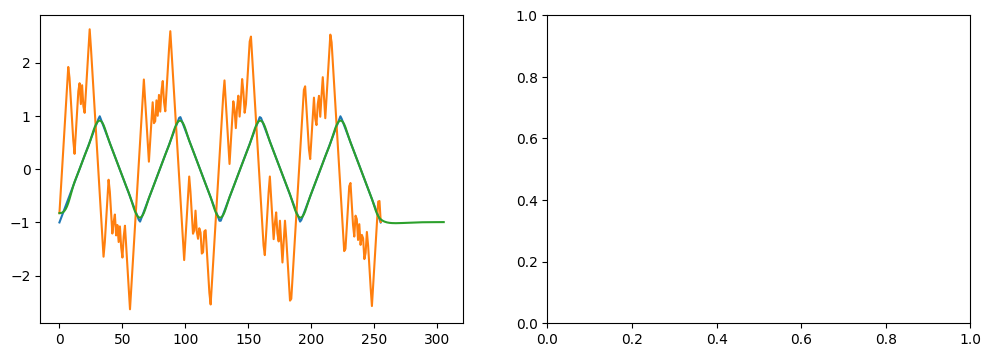

In [15]:

# b, a, dt = _trap_filter
# n_pad = 100
# tt = _t * dt * 1e6
# tf = np.arange(len(waveform0) + n_pad) * dt * 1e6
# waveform_filt = lfilter_waveform(b, a, waveform0, pad_after=n_pad)
# voltage = voltage0
# waveform = pad_waveform(waveform0, n_pad)


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(voltage0)
ax.plot(waveform0.value)
ax.plot(waveform_filtered.value)

In [16]:

b, a, dt = _trap_filter
n_pad = 100
tt = _t * dt * 1e6
tf = np.arange(len(waveform0) + n_pad) * dt * 1e6
waveform_filt = lfilter_waveform(b, a, waveform0, pad_after=n_pad)
voltage = voltage0
waveform = pad_waveform(waveform0, n_pad)


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(voltage)
ax.plot( waveform)
ax.plot( waveform_filt)
# plt.ylim(-2.3, 2.3)

dv = np.gradient(voltage, tt, axis=0)
dw = np.gradient(waveform, tf, axis=0)

ax1.plot(tt, dv)
ax1.plot(tf, dw)

ax.axvline(256)




TypeError: object of type 'Variable' has no len()

In [ ]:
waveform.shape

(356, 1)